In [109]:
from typing import List

import matplotlib.pyplot as plt
import numpy as np
import torch
from checker import test_optimizer
from utils import visualize_optimizer

# Optymalizatory

Notebook jest luźno wzorowany na [przeglądzie Sebastiana Rudera](https://ruder.io/optimizing-gradient-descent/index.html).

Państwa dzisiejszym zadaniem będzie zaimplementowanie najpopularniejszych optymalizatorów stosowanych w uczeniu maszynowym.

Każda z implementowanych przez Państwa klas dziedziczy po klasie `Optimizer`, w której gotowe są już pewne funkcjonalności. Państwa zadanie to przeładowanie metody `step` (oraz naturalnie dodawanie wymaganych rzeczy do konstruktora).

Ogólne uwagi do zadań:
* **Proszę zwrócić uwagę na modyfikowanie tensorów in-place (-=) tak aby oryginalne tensory zostały zmodyfikowane.**
* Proszę zwracać uwagę przy zmienianiu parametrów w środku optimizera, tak aby faktycznie je zmieniać. Można wzorować się na poniższej implementacji `GradientDescent`.
* Kolejność wzorów w sekcjach "Update" kolejnych metod jest jednocześnie zalecaną kolejnością implementacji.

In [110]:
class Optimizer:
    """Base class for each optimizer"""

    def __init__(self, initial_params):
        # store model weights
        self.params = initial_params

    def step(self):
        """Updates the weights stored in self.params"""
        raise NotImplementedError()

    def zero_grad(self):
        """Torch accumulates gradients, so we need to clear them after every update"""
        for param in self.params:
            if param.grad is not None:
                param.grad.detach_()
                param.grad.zero_()


class GradientDescent(Optimizer):
    def __init__(self, initial_params: List[torch.tensor], learning_rate):
        super().__init__(initial_params)
        self.learning_rate = learning_rate

    @torch.no_grad()
    def step(self):
        for param in self.params:
            # Please note that it's important to change the parameters in-place (-=) so the original tensors are modified
            param -= self.learning_rate * param.grad

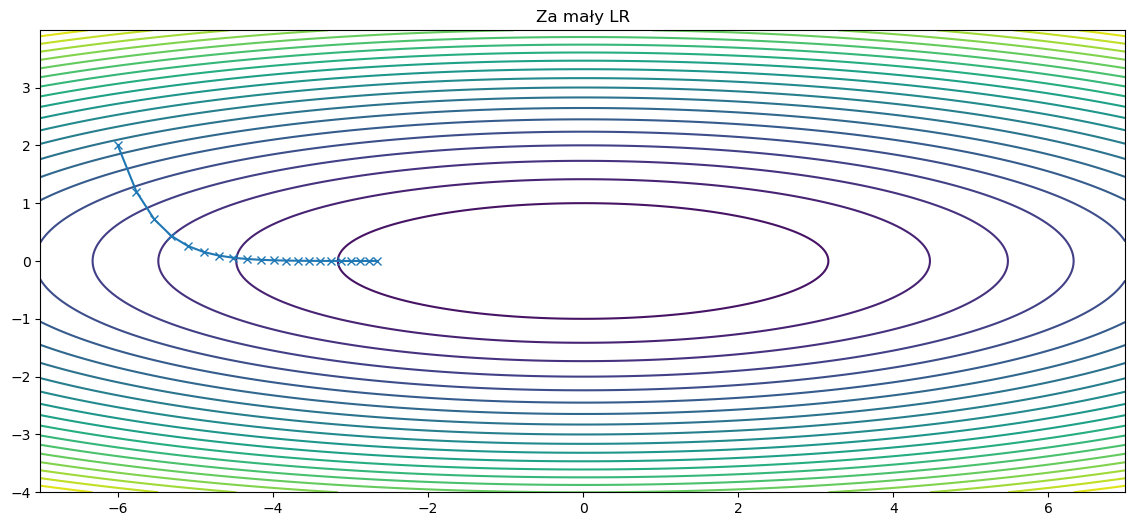

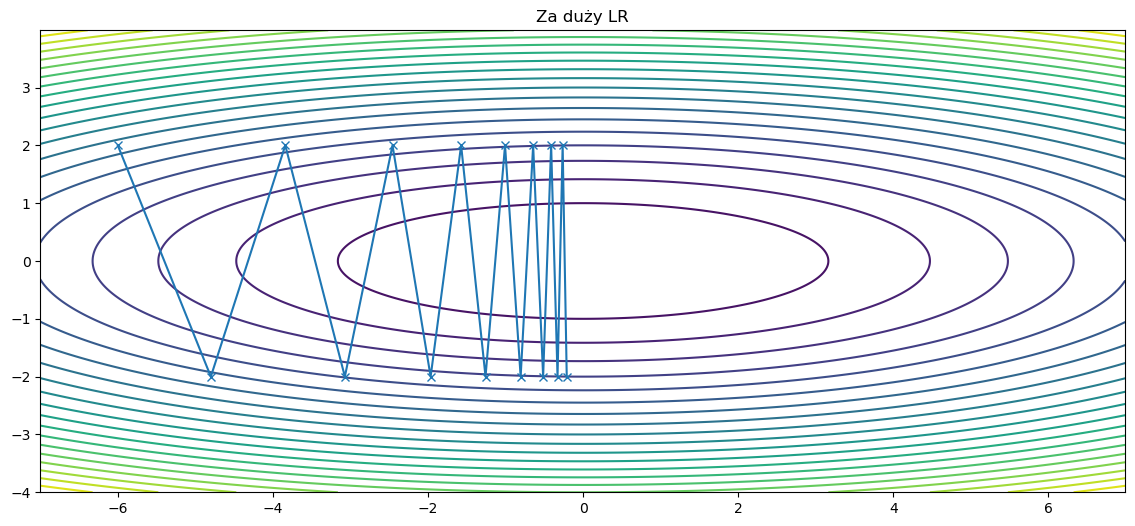

In [111]:
visualize_optimizer(GradientDescent, n_steps=20, learning_rate=0.1, title="Za mały LR")
visualize_optimizer(GradientDescent, n_steps=15, learning_rate=0.5, title="Za duży LR")

## Momentum
Hiperparamerty:
* $\eta$ - Learning Rate (typowe wartości: od 0.001 do 0.01)
* $\gamma$ - Momentum (zawsze < 1, typowo 0.9)

### Update
Zmiany dokonywane są na podstawie wektora "pędu" (ang. *momentum*) $\Delta$, który rośnie jeżeli dokonujemy zmian w tym samym kierunku.

<font size="+2"> $$ \Delta_{t+1} = \gamma  \Delta_{t} + \eta \nabla_\theta \mathcal{L}(\theta_t) $$ </font><br>
<font size="+2"> $$ \theta_{t+1} = \theta_{t} - \Delta_{t+1} $$ </font>


In [112]:
class Momentum(Optimizer):
    
    def __init__(self, initial_params, learning_rate, gamma):
        super().__init__(initial_params)
        
        self.learning_rate = learning_rate
        self.gamma = gamma
        self.deltas = []
        for param in self.params:
            self.deltas.append(torch.zeros_like(param))
    
    @torch.no_grad()
    def step(self):
        for param, delta in zip(self.params, self.deltas):
            delta *= self.gamma
            delta += self.learning_rate * param.grad
            param -= delta

In [113]:
test_optimizer(Momentum)

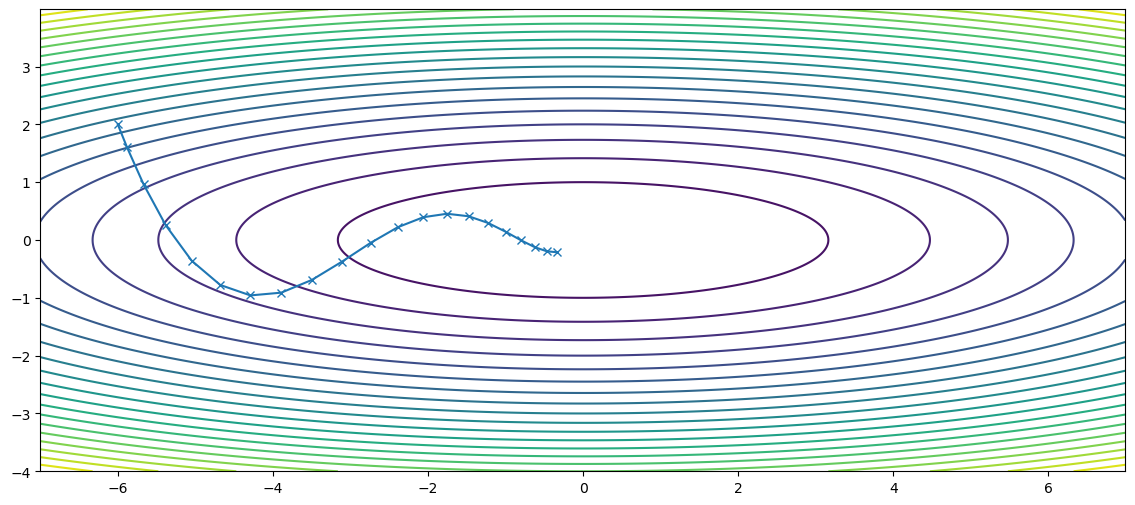

In [114]:
visualize_optimizer(Momentum, n_steps=20, learning_rate=0.05, gamma=0.8)

## Adagrad  (1 pkt.)
Hiperparamerty:
* $\eta$ - Learning Rate (typowe wartości: od 0.001 do 0.01)
* $\epsilon$ - Dodawany do mianownika w celu uniknięcia dzielenia przez 0 (typowo $10^{-8}$)

### Update
W każdym kroku adaptujemy stałą uczenia $\eta$ dla każdego z wymiarów wag na podstawie sumy kwadratów dotychczasowych gradientów.

<font size="+2"> $$ \displaystyle  G_t = \sum_{i = 1}^{t} \big(\nabla_\theta \mathcal{L}(\theta_i)\big)^2 $$ </font>

<font size="+2"> $$ \theta_{t+1} = \theta_t - \frac{\eta}{\sqrt{G_t + \epsilon}} \odot \nabla_\theta \mathcal{L}(\theta_t) $$ </font>



<font size="+0"> gdzie $G_t$ to suma kwadratów gradientów $\nabla_\theta \mathcal{L}(\theta_i)^2$ dla kroków $i = 1, .., t$ </font>

##### Uwagi
* $G_0 = \mathbf{0}$, wymiar taki sam jak $\theta$.
* $\odot$ to mnożenie *element-wise*.
* podnoszenie gradientu do kwadratu jest robione *element-wise*.

In [115]:
class Adagrad(Optimizer):

    def __init__(self, initial_params, learning_rate, epsilon):
        super().__init__(initial_params)
        self.learning_rate = learning_rate
        self.epsilon = epsilon

        self.gs = []
        for param in self.params:
            self.gs.append(torch.zeros_like(param))

    @torch.no_grad()
    def step(self):
        for param, g in zip(self.params, self.gs):
            c = param.grad
            g += c ** 2
            param -= self.learning_rate / (torch.sqrt(g + self.epsilon)) * c
        

In [116]:
test_optimizer(Adagrad)

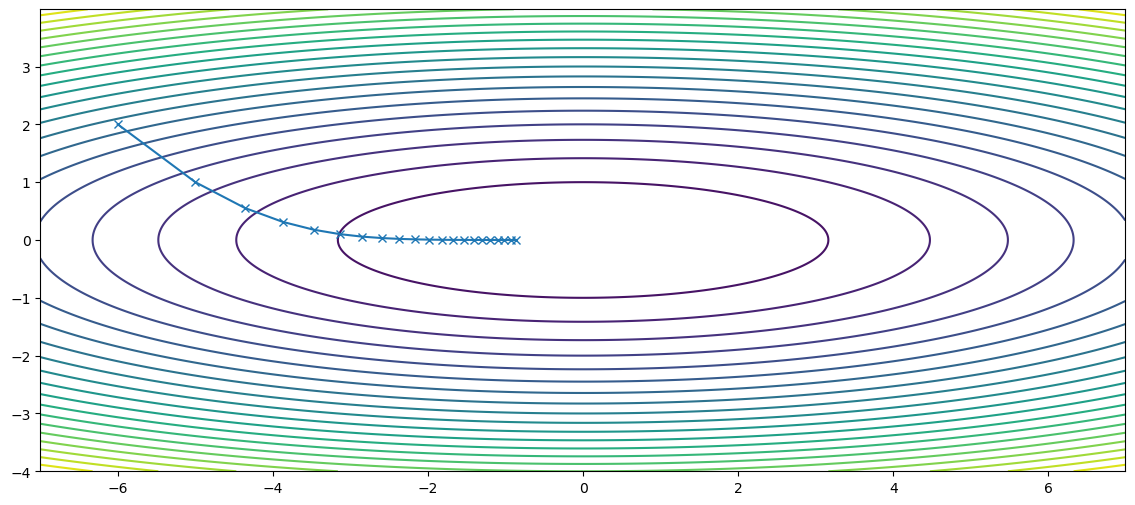

In [117]:
visualize_optimizer(Adagrad, n_steps=20, learning_rate=1.0, epsilon=1e-8)

## RMSProp  (1 pkt.)
Hiperparametry:
* $\eta$ - Learning Rate (typowe wartości: od 0.001 do 0.01)
* $\gamma$ - Współczynnik średniej kroczącej (typowo 0.9)
* $\epsilon$ - Dodawany do mianownika w celu uniknięcia dzielenia przez 0 (typowo $10^{-8}$)

### Update
Analogicznie dla algorytmu *Adagrad* adaptujemy stałą uczenia, lecz tym razem zamiast sumy, robimy to średnią kroczącą ze współczynnikiem $\gamma$.

<font size="+2"> $$ H_{t+1} = \gamma H_{t} + (1 - \gamma) \big( \nabla_\theta \mathcal{L}(\theta_t)\big)^2 $$ </font>

<font size="+2"> $$ \theta_{t+1} = \theta_t - \frac{\eta}{\sqrt{H_{t+1} + \epsilon}} \odot \nabla_\theta \mathcal{L}(\theta_t) $$ </font>



gdzie $H_t$ to średnia krocząca kwadratów gradientów $(\nabla_\theta \mathcal{L}(\theta_t))^2$ z kroków $0, 1, ..., t$ ze współczynnikiem $\gamma$.

#### Uwagi
* $H_0 = \mathbf{0}$, wymiar taki sam jak $\theta$.
* $\odot$ to mnożenie *element-wise*.
* podnoszenie gradientu do kwadratu jest robione *element-wise*.

In [118]:
class RMSProp(Optimizer):
    
    def __init__(self, initial_params, learning_rate, gamma, epsilon):
        super().__init__(initial_params)
        self.learning_rate = learning_rate
        self.gamma = gamma
        self.epsilon = epsilon
        
        self.hs = []
        for param in self.params:
            self.hs.append(torch.zeros_like(param))

    @torch.no_grad()
    def step(self):
        for param, h in zip(self.params, self.hs):
            grad = param.grad
            h *= self.gamma
            h += (1 - self.gamma) * grad ** 2
            
            param -= (self.learning_rate / torch.sqrt(h + self.epsilon)) * grad
         # your code here
            

In [119]:
test_optimizer(RMSProp)

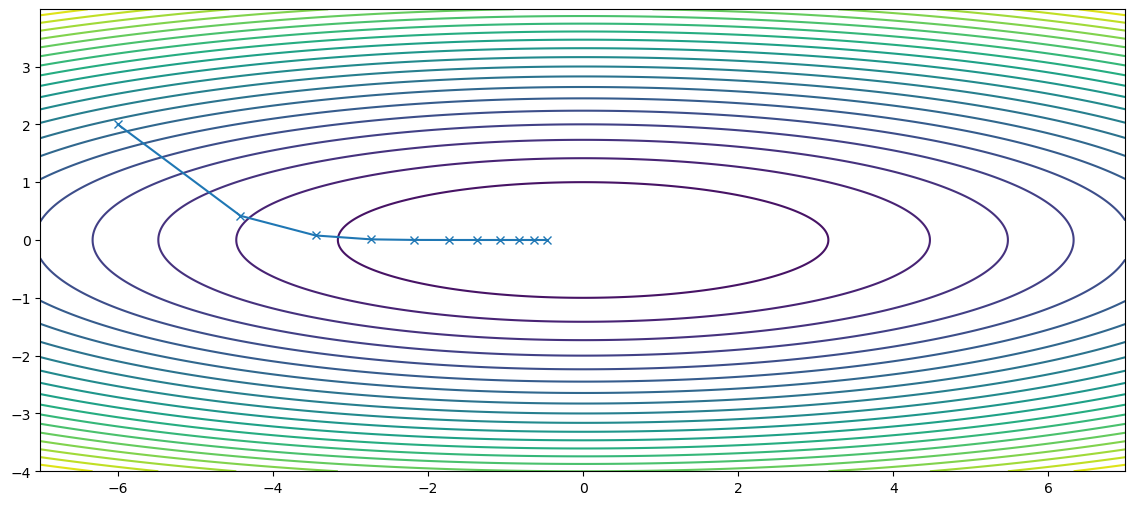

In [120]:
visualize_optimizer(RMSProp, n_steps=10, learning_rate=0.5, gamma=0.9, epsilon=1e-8)

## Adam (2 pkt.)

Hiperparametry:
* $\eta$ - Learning Rate (typowo 0.001)
* $\beta_1$ - współczynnik średniej kroczącej pierwszego momentu (typowo 0.9)
* $\beta_2$ - współczynnik średniej kroczącej drugiego momentu (typowo 0.999)
* $\epsilon$ - zapobiega dzieleniu przez zero (typowo $10^{-8}$)

### Update
Adaptujemy gradient dwiema średnimi kroczącymi, pierwszego $m$ i drugiego $v$ momentu. Na początku uczenia te średnie są bardzo zbiasowane do 0, stąd wprowadzane są poprawka $\hat{m}$ i $\hat{v}$, im dalej w procesie uczenia, tym te poprawki wprowadzają mniejsze zmiany.  

<font size="+2"> $$ m_{t+1} = \beta_1 m_{t} + (1 - \beta_1)  \nabla_\theta \mathcal{L}(\theta_t) $$ </font>
<font size="+2"> $$ v_{t+1} = \beta_2 v_{t} + (1 - \beta_2)  \big( \nabla_\theta \mathcal{L}(\theta_t) \big)^2 $$ </font>
<br>
<font size="+2"> $$  \hat{m} = \frac{m_{t+1}}{1 - \beta_1^{(t+1)}} $$ </font><br>
<font size="+2"> $$  \hat{v} = \frac{v_{t+1}}{1 - \beta_2^{(t+1)}} $$ </font>
<br>
<font size="+2"> $$ \theta_{t+1} = \theta_t - \eta \frac{\hat{m}}{\sqrt{\hat{v}} + \epsilon} $$ </font>

#### Uwagi
* $m_0 = \mathbf{0}$, wymiar taki sam jak $\theta$.
* $v_0 = \mathbf{0}$, wymiar taki sam jak $\theta$. 
* $\beta_1^{(t+1)}$ oraz $\beta_2^{(t+1)}$ to potęgowania.
* podnoszenie gradientu do kwadratu jest robione *element-wise*.


In [121]:
class Adam(Optimizer):
   
    def __init__(self, initial_params, learning_rate, beta1, beta2, epsilon):
        super().__init__(initial_params)
        self.learning_rate = learning_rate
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon
        
        self.ms = []
        self.vs = []
        self.t = 0
        for param in self.params:
            self.ms.append(torch.zeros_like(param))
            self.vs.append(torch.zeros_like(param))
    
        # your code here
        
    @torch.no_grad()
    def step(self,):
        self.t += 1
        for i, (param, m, v) in enumerate(zip(self.params, self.ms, self.vs)):
            grad = param.grad
            
            m *= self.beta1
            m += (1 - self.beta1) * grad
            
            v *= self.beta2
            v += (1 - self.beta2) * (grad * grad)
            
            m_dash = m / (1 - (self.beta1 ** self.t))
            v_dash = v / (1 - (self.beta2 ** self.t))
            
            param -= self.learning_rate * m_dash / (torch.sqrt(v_dash) + self.epsilon)
        # your code here
        

In [122]:
test_optimizer(Adam)

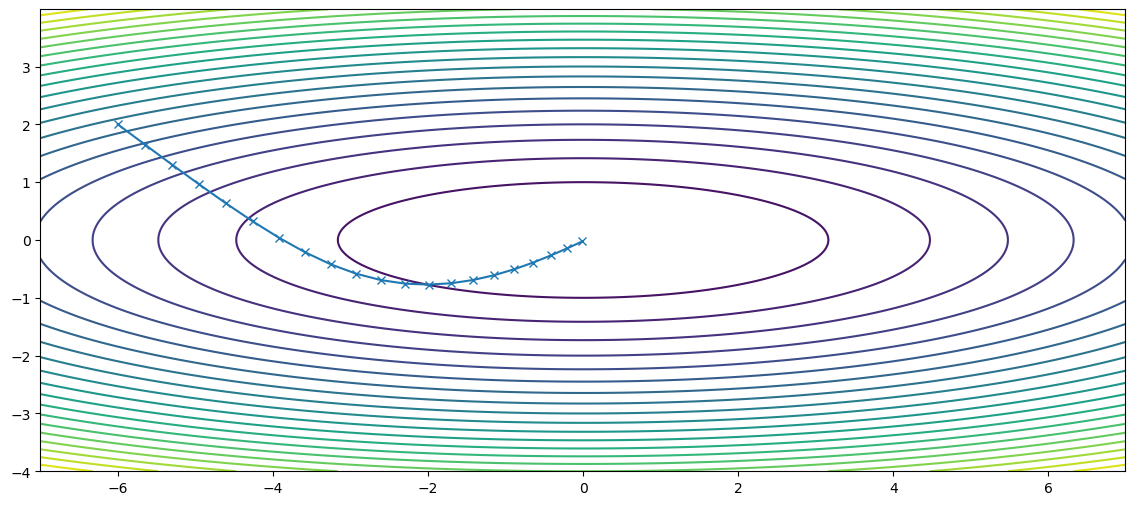

In [123]:
visualize_optimizer(Adam, n_steps=20, learning_rate=0.35, beta1=0.9, beta2=0.999, epsilon=1e-8)